In [0]:

!pip install sklearn-crfsuite seqeval

In [0]:
!pip install tensorflow keras

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-x43hxc36
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-x43hxc36
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=c41a8d464171691716bba4846f445aec0b3776f2271394edbe048c0ae115d9b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-arbhcwjv/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
#import libraries
import pandas as pd
import numpy as np
%tensorflow_version 1.13.1
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
#Reading the csv file
df = pd.read_csv('ner_dataset.csv', encoding = "ISO-8859-1")

In [0]:
#Display first 10 rows
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [0]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 33210,the,NN,O
freq,1,52573,145807,887908


In [0]:
#Displaying the unique Tags
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [0]:
#Checking null values, if any.
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [0]:
df = df.fillna(method = 'ffill')

In [0]:
# This is a class to get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [0]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [0]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [0]:
sentences = getter.sentences

In [0]:
# Number of data points passed in each iteration
batch_size = 64 
# Passes through entire dataset
epochs = 5
# Maximum length of review
max_len = 75 
# Dimension of embedding vector
embedding = 40 

In [0]:
#Getting unique words and labels from data
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [0]:
print("The word India is identified by the index: {}".format(word_to_index["India"]))
print("The label B-org for the organization is identified by the index: {}".format(tag_to_index["B-org"]))

The word India is identified by the index: 2570
The label B-org for the organization is identified by the index: 6


In [0]:
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]

# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])
X[0]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 11, 17,
        3, 18, 19, 20, 21, 22, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [0]:
# Convert label to index
y = [[tag_to_index[w[2]] for w in s] for s in sentences]

# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [0]:
num_tag = df['Tag'].nunique()
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [0]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (40765, 75)
Size of training output data :  (40765, 75, 18)
Size of testing input data :  (7194, 75)
Size of testing output data :  (7194, 75, 18)


In [0]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])

*****Before Processing first sentence : *****
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 11 17  3 18 19 20 21 22 23
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [0]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[2] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
*****After Processing first sentence : *****
  [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [0]:
num_tags = df['Tag'].nunique()
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 40)            1407200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 18)            1278      
Total params: 1,449,928
Trainable params: 1

In [0]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [0]:
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])




Train on 36688 samples, validate on 4077 samples
Epoch 1/5





36688/36688 [==============================] - 133s 4ms/step - loss: 0.1655 - crf_viterbi_accuracy: 0.9563 - val_loss: 0.0424 - val_crf_viterbi_accuracy: 0.9843
Epoch 2/5
36688/36688 [==============================] - 130s 4ms/step - loss: 0.0243 - crf_viterbi_accuracy: 0.9880 - val_loss: 0.0165 - val_crf_viterbi_accuracy: 0.9881
Epoch 3/5
36688/36688 [==============================] - 130s 4ms/step - loss: 0.0054 - crf_viterbi_accuracy: 0.9908 - val_loss: 0.0035 - val_crf_viterbi_accuracy: 0.9896
Epoch 4/5
36688/36688 [==============================] - 131s 4ms/step - loss: -0.0062 - crf_viterbi_accuracy: 0.9918 - val_loss: -0.0070 - val_crf_viterbi_accuracy: 0.9901
Epoch 5/5
36688/36688 [==============================] - 131s 4ms/step - loss: -0.0162 - crf_viterbi_accuracy: 0.9924 - val_loss: -0.0162 - val_crf_viterbi_accuracy: 0.9905


In [0]:
model.save("new_model")

In [0]:
history.history.keys()

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])

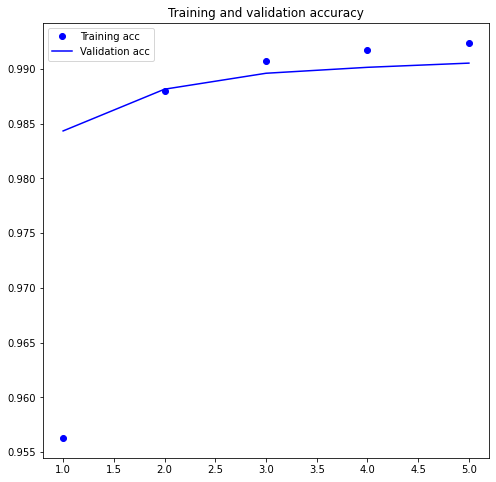

In [0]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

In [0]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [0]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [0]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 88.1%


In [0]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        75
       B-eve       0.38      0.24      0.29        38
       B-geo       0.83      0.91      0.87      5652
       B-gpe       0.97      0.93      0.95      2405
       B-nat       0.00      0.00      0.00        32
       B-org       0.83      0.66      0.73      3023
       B-per       0.82      0.85      0.83      2619
       B-tim       0.92      0.87      0.90      3029
       I-art       0.00      0.00      0.00        56
       I-eve       0.05      0.03      0.04        34
       I-geo       0.74      0.80      0.77      1063
       I-gpe       1.00      0.64      0.78        33
       I-nat       0.00      0.00      0.00         6
       I-org       0.82      0.73      0.78      2573
       I-per       0.83      0.92      0.87      2733
       I-tim       0.80      0.74      0.77       993
           O       0.99      0.99      0.99    131708
         PAD       1.00    

In [0]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b
print(X_test[i])
print(np.array(X_test[i]).shape)
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

[  964    47  2586  2598    13  5195   339    95   127   174 31409  1463
  4422  9593  2598 27465   225  7688   190  2592   525   367   280    47
   952  3986  3983    23     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
(75,)
Sample number 4574 of 7194 (Test Set)
Word           ||True ||Pred
At             : O     O
a              : O     O
coal           : O     O
mine           : O     O
in             : O     O
Henan          : B-geo B-geo
province       : O     O
,              : O     O
officials      : O     O
said           : O     O
divers         : O     O
would          : O     O
search         : O     O
flooded        : O     O
mine           : O     O
shafts         : O     O
for            : O     O
42             : O     O
workers        

In [0]:
inp = "Obama was the best president of America ."
inp = inp.split()

In [0]:
print(inp)
new = []
for i in inp:
    try:
        new.append(word_to_index[i])
    except:
        new.append(word_to_index["UNK"])
for i in range(max_len - len(new)):
    new.append(0)
newinp = np.array(new).reshape(75,)
np.array(newinp).shape
pred = model.predict(np.array([newinp]))

['Obama', 'was', 'the', 'best', 'president', 'of', 'America', '.']


In [0]:
pos = []
for i in pred:
    for j in i:
        for k in range(len(j)):
            if j[k]==1:
                pos.append(k)
print(pos)

[4, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [0]:
for i in range(len(inp)):
    print("{:15}:  {} ".format(inp[i],tags[pos[i]-1]))

Obama          :  B-per 
was            :  O 
the            :  O 
best           :  O 
president      :  O 
of             :  O 
America        :  B-geo 
.              :  O 


In [0]:
lst = []
for i in range(5):
    f = open("doc"+str(i+1)+".txt", "r",encoding="utf-8")
    x = []
    x = f.readlines()
    y = x[0].split()
    lst.append(y)

In [0]:
print(lst)
temp = lst

[['The', 'son', 'of', 'a', 'white', 'American', 'mother', 'and', 'a', 'black', 'Kenyan', 'father', 'Obama', 'grew', 'up', 'in', 'Hawaii', 'Leaving', 'the', 'state', 'to', 'attend', 'college', 'he', 'earned', 'degrees', 'from', 'Columbia', 'University', 'and', 'Harvard', 'Law', 'School', 'Obama', 'worked', 'as', 'a', 'community', 'organizer', 'in', 'Chicago', 'where', 'he', 'met', 'and', 'married', 'Michelle', 'LaVaughn', 'Robinson', 'in', '1992', 'Their', 'two', 'daughters', 'Malia', 'Ann', 'and', 'Natasha', 'were', 'born', 'in', '1998', 'and', '2001', 'respectively', 'Obama', 'was', 'elected', 'to', 'the', 'Illinois', 'state', 'senate', 'in', '1996', 'and', 'served', 'there', 'for', 'eight', 'years', 'In', '2004', 'he', 'was', 'elected', 'by', 'a', 'record', 'majority', 'to', 'the', 'US', 'Senate', 'from', 'Illinois', 'and', 'in', 'February', '2007', 'announced', 'his', 'candidacy', 'for', 'president', 'After', 'winning', 'a', 'closely', 'fought', 'contest', 'against', 'New', 'York', 

In [0]:
for i in range(len(temp)):
    for j in range(len(temp[i])):
        try:
            temp[i][j] = word_to_index[temp[i][j]]
        except:
            temp[i][j] = word_to_index["UNK"]

In [0]:
print(temp)

[[63, 2526, 3, 47, 5683, 331, 5684, 15, 47, 507, 2556, 627, 2196, 7930, 456, 13, 12435, 1, 11, 1301, 9, 4056, 4580, 504, 1929, 1044, 20, 21624, 1493, 15, 25915, 8107, 6966, 2196, 888, 36, 47, 2773, 3630, 13, 15993, 253, 504, 1963, 15, 9666, 9735, 1, 18806, 13, 4136, 7354, 982, 26475, 1, 20321, 15, 33891, 191, 5682, 13, 4552, 15, 568, 6655, 2196, 61, 4917, 9, 11, 3978, 1301, 19495, 13, 6990, 15, 1521, 598, 225, 2041, 645, 347, 612, 504, 61, 4917, 193, 47, 2105, 393, 9, 11, 3172, 1498, 20, 3978, 15, 13, 4397, 3255, 819, 498, 10055, 225, 278, 1966, 376, 47, 9322, 2373, 12220, 314, 1382, 4268, 1480, 15, 477, 3263, 22596, 4503, 4504, 2705, 225, 11, 2394, 4512, 2196, 1, 6582, 1480, 1481, 5948, 3, 3624, 11, 1485, 5947, 225, 278, 13, 11, 1189, 2181, 23], [2570, 80, 47, 3808, 22, 253, 326, 2797, 1820, 20606, 399, 11, 600, 3679, 80, 30899, 2570, 80, 147, 3, 1820, 14918, 1, 2010, 15, 30049, 399, 129, 1251, 788, 11, 599, 2570, 80, 4384, 225, 11, 5461, 931, 3, 2570, 80, 11, 22, 13, 11, 9102, 936], 

In [0]:
for j in range(len(temp)):
    i=0
    while (len(temp[j]))%75!=0:
        temp[j].append(0)
        i=i+1

In [0]:
for i in range(len(temp)):
    temp[i] = np.array(temp[i]).reshape(int(len(temp[i])/75),75)

In [0]:
b = []
for i in range(len(temp)):
    c = []
    for j in range(len(temp[i])):
        newinp = np.array(temp[i][j]).reshape(75,)
        np.array(newinp).shape
        pred = model.predict(np.array([newinp]))
        pos = []
        for k in pred:
            for l in k:
                for k in range(len(l)):
                    if l[k]==1:
                        pos.append(k)
        c.append(pos)
    b.append(c)

In [0]:
import itertools

In [0]:
for i in range(len(b)):
    b[i] = list(itertools.chain.from_iterable(b[i]))

ERROR! Session/line number was not unique in database. History logging moved to new session 68


In [0]:
for i in range(len(b)):
    b[i]=list(filter(lambda a: a != 0, b[i]))

In [0]:
lst_n = []
for i in range(5):
    f = open("doc"+str(i+1)+".txt", "r",encoding="utf-8")
    x = []
    x = f.readlines()
    y = x[0].split()
    lst_n.append(y)

In [0]:
search = []
for i in range(len(b)):
    se = []
    for j in range(len(b[i])):
        if b[i][j]!=1:
            se.append(lst_n[i][j])
    se.append("doc"+str(i+1))
    search.append(se)

In [0]:
print(search)

[['American', 'Kenyan', 'Obama', 'Hawaii', 'Leaving', 'University', 'and', 'Harvard', 'Law', 'School', 'Obama', 'Chicago', 'Michelle', 'LaVaughn', 'Robinson', '1992', 'Malia', 'Ann', 'Natasha', '1998', 'and', '2001', 'Obama', 'Illinois', '1996', 'eight', '2004', 'US', 'Senate', 'Illinois', 'February', '2007', 'New', 'York', 'Senator', 'Lady', 'Hillary', 'Rodham', 'Clinton', 'Obama', 'handily', 'Senator', 'John', 'McCain', 'Arizona', 'doc1'], ['India', 'India', 'India', 'India', 'doc2'], ['German', 'West', 'Germanic', 'Central', 'Europe', 'Germany', 'Austria', 'Switzerland', 'South', 'Tyrol', 'Italy', 'Germanspeaking', 'Community', 'of', 'Belgium', 'and', 'Liechtenstein', 'Luxembourg', 'Opole', 'Voivodeship', 'Poland', 'German', 'West', 'Germanic', 'Dutch', 'Frisian', 'languages', 'Low', 'GermanLow', 'Saxon', 'Luxembourgish', 'and', 'Yiddish', 'vocabulary', 'Danish', 'Norwegian', 'Swedish', 'North', 'Germanic', 'German', 'doc3'], ['1945', '25', 'United', 'National', 'Organization', 'Lea

In [0]:
search_text = "Obama"

In [0]:
for i in range(len(search)):
    for j in range(len(search[i])):
        if search_text==search[i][j]:
            print(search[i][-1])

doc1
doc1
doc1
doc1


In [0]:
search_text = "German"

In [0]:
for i in range(len(search)):
    for j in range(len(search[i])):
        if search_text==search[i][j]:
            print(search[i][-1])

doc3
doc3
doc3


In [0]:
search_text = "China"

In [0]:
for i in range(len(search)):
    for j in range(len(search[i])):
        if search_text==search[i][j]:
            print(search[i][-1])

doc5
doc5
